In [1]:
library(tidyverse)
library(arrow)
library(cowplot)
library(duckplyr)
library(yardstick)

── Attaching core tidyverse packages ───────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘arrow’


The following object is masked from ‘package:lubridate’:

    duration


The following object is masked from ‘package:utils’:

    timestamp



Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp



Attaching package: ‘ggpubr’


The following ob

# and/or/mul phenotypes fit vs anonymity

In [2]:
per_phenotype_vs_anon_df <- duckplyr_df_from_parquet("data/gwas-comparison.parquet") |> 
    filter(sumstat == "CHISQ") |>
    select(-exact) |>
    pivot_wider(names_from = k, values_from = approx) |>
    rename(de_anon = `1`) |>
    pivot_longer(c(-phenotype, -ID, -sumstat, -operator, -de_anon), names_to = "k", values_to = "anon") |>
    group_by(phenotype, operator, sumstat, k) |>
    summarize(rsq = rsq_vec(de_anon, anon), .groups = "drop")

per_phenotype_vs_anon_df |> head(2)

duckplyr: materializing


Warning message:
“There were 12 warnings in `summarize()`.
The first warning was:
ℹ In argument: `rsq = rsq_vec(de_anon, anon)`.
ℹ In group 199: `phenotype = "and_H15_F50"`, `operator = "and"`, `sumstat = "CHISQ"`, `k = "10"`.
Caused by warning:
! A correlation computation is required, but the inputs are size zero or one and the standard deviation cannot be computed. `NA` will be returned.
ℹ Run `dplyr::last_dplyr_warnings()` to see the 11 remaining warnings.”


phenotype,operator,sumstat,k,rsq
<chr>,<chr>,<chr>,<chr>,<dbl>
and_B00_E16,and,CHISQ,10,0.5077256
and_B00_E16,and,CHISQ,100,0.1322200


Warning message:
“Removed 12 rows containing non-finite outside the scale range (`stat_boxplot()`).”
Warning message:
“Removed 12 rows containing missing values or values outside the scale range (`geom_line()`).”
Warning message:
“Removed 12 rows containing missing values or values outside the scale range (`geom_point()`).”


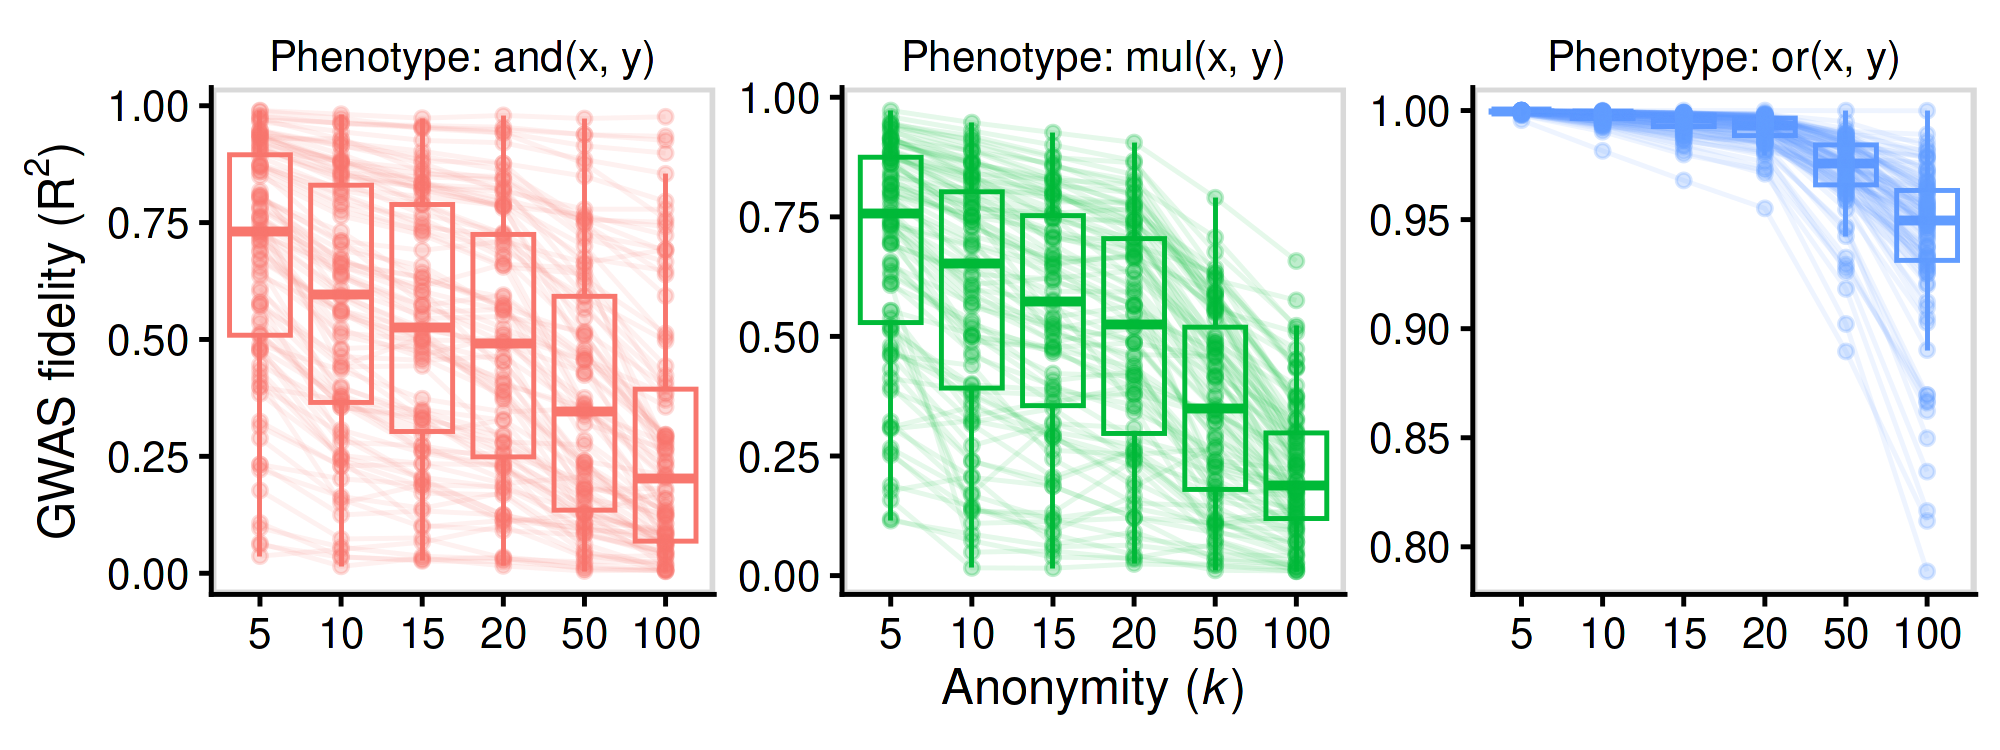

In [3]:
options(repr.plot.height = 3, repr.plot.width = 8, repr.plot.res = 250)

gwas_fidelity_plot <- per_phenotype_vs_anon_df |>
    mutate(k = factor(k, levels = c("5", "10", "15", "20", "50", "100"))) |>
    ggplot(aes(y = rsq, x = k, color = operator)) +
    geom_boxplot(aes(group = interaction(k, operator)), position = position_dodge(width = 1), outlier.shape = NA) +
    # geom_violin(aes(group = interaction(k, operator)), position = position_dodge(width = 1), scale = "width") +
    geom_line(aes(group = phenotype), alpha = 0.1) +
    geom_point(alpha = 0.25) +
    facet_wrap(vars(operator), scales = "free", labeller = labeller(operator = function(s) str_glue("Phenotype: {s}(x, y)"))) +
    theme_cowplot() +
    theme(
        legend.position = "none",
        strip.background = element_blank(),
    ) +
    panel_border() +
    xlab(expression("Anonymity ("*italic(k)*")")) +
    ylab(expression("GWAS fidelity ("*R^2*")"))

gwas_fidelity_plot

# Noise pheno vs gwas plot

In [4]:
plot_df <- read_parquet("data/noise_pheno_fit.parquet") |>
    inner_join(read_parquet("data/noise_gwas_fit.parquet"), by = c("underlying", "i"), suffix = c("_pheno", "_gwas"))

plot_df |> head(2)

underlying,i,rsq_pheno,rsq_gwas
<chr>,<int>,<dbl>,<dbl>
A04,1,0.24976911,0.15691379
A04,2,0.07327306,0.06026544


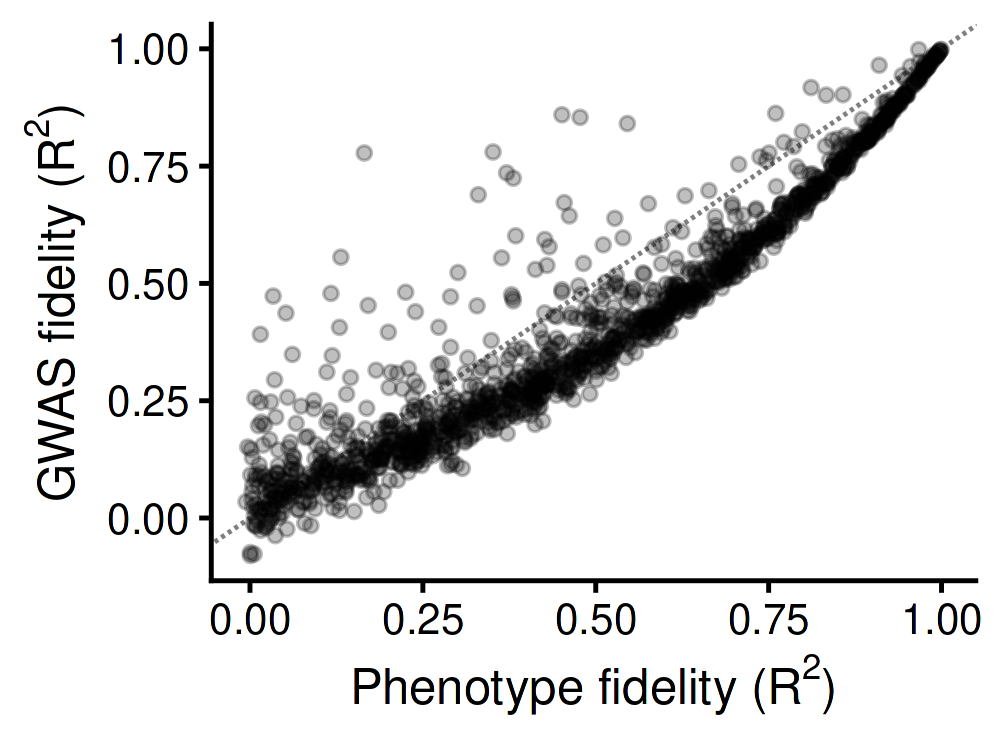

In [5]:
options(repr.plot.width = 4, repr.plot.height = 3, repr.plot.res = 250)

pheno_vs_gwas_plot <- plot_df |>
    ggplot(aes(x = rsq_pheno, y = rsq_gwas)) +
    geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "gray50") +
    geom_point(alpha = 0.25) +
    theme_cowplot() +
    xlab(expression("Phenotype fidelity ("*R^2*")")) +
    ylab(expression("GWAS fidelity ("*R^2*")"))

pheno_vs_gwas_plot

# Combine plots

Warning message:
“Removed 12 rows containing non-finite outside the scale range (`stat_boxplot()`).”
Warning message:
“Removed 12 rows containing missing values or values outside the scale range (`geom_line()`).”
Warning message:
“Removed 12 rows containing missing values or values outside the scale range (`geom_point()`).”


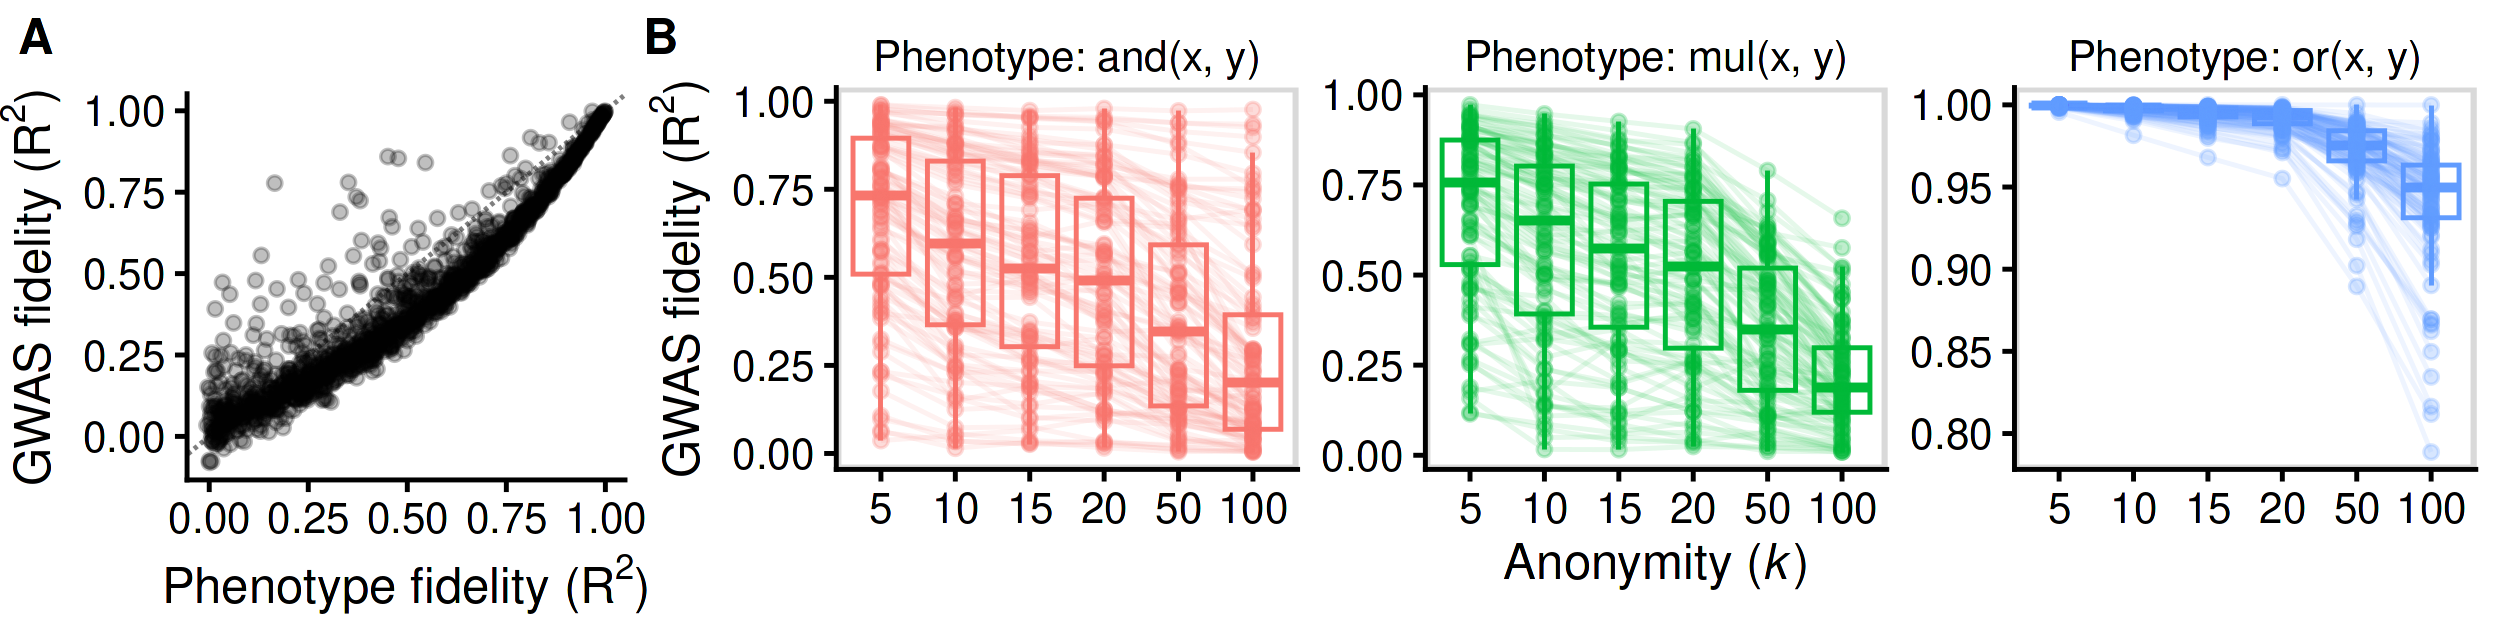

In [6]:
options(repr.plot.width = 10, repr.plot.height = 2.5, repr.plot.res = 250)

combined_plot <- plot_grid(
    pheno_vs_gwas_plot + theme(plot.margin = unit(c(0.15, 0, 0, 0), "npc")),
    gwas_fidelity_plot,
    nrow = 1, rel_widths = c(1, 3), labels = c("A", "B")
)

save_plot("img/pheno_vs_gwas_and_anonymity.png", combined_plot, base_width = 10, base_height = 2.5, dpi = 400)

combined_plot